# Answering Business Questions Using SQL

In this project, we will be using SQL to answer several business questions about a fictional music store called Chinook. We have Chinook's music database which contains all sorts of information related to artists, songs, albums, playlists, etc. In addition, the database also contains information about the customers who buy their music. Below is the schema of our database where we can see how our various tables are connected to one another.

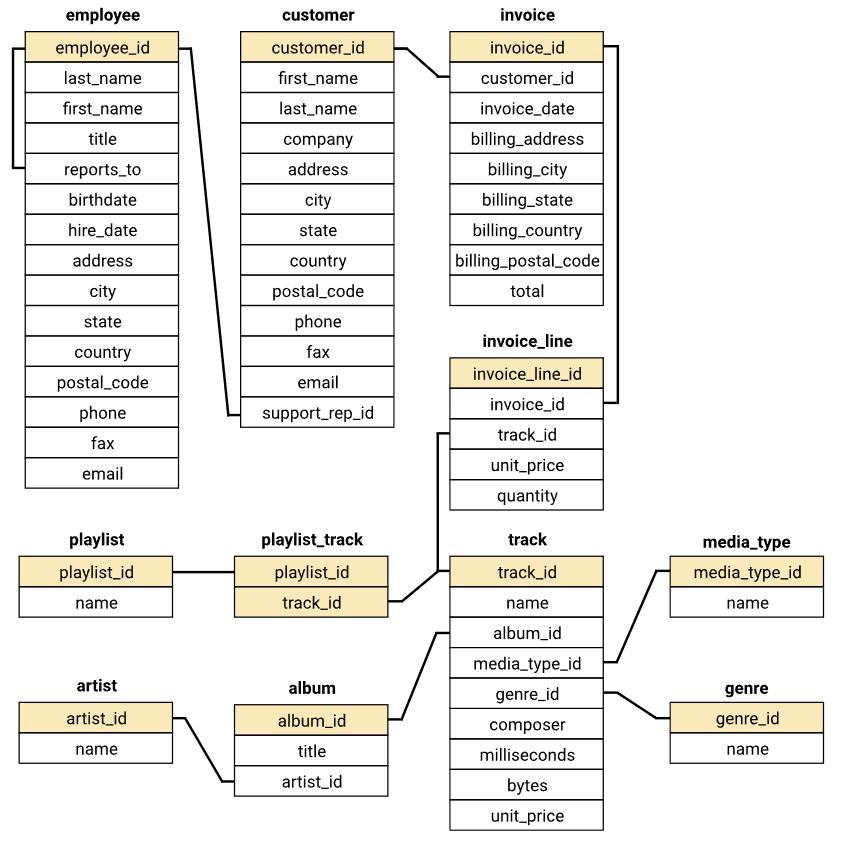

## Project Goals

Over the course of this project, we want to investigate and answer several questions including:

* Which genres sell the most tracks in the U.S.?
* How are the sales support agents performing?
* Can we collate data on purchases from other countries?
* What do customers buy more of: whole albums or individual tracks?
* What artist is used in the most playlists?
* What percentage of tracks have been purchased vs. not purchased?
* Do customers care about protected vs. non-protected media?

Before we begin, we need to connect to our database.

# Import Libraries & Tools

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot
import sqlite3

With our database connected, let's begin by exploring some of the data inside:

In [2]:
%%capture
%load_ext sql
%sql sqlite:///chinook.db

In [3]:
%%sql
SELECT name,
       type
FROM sqlite_master
WHERE type IN ("table","view");

 * sqlite:///chinook.db
Done.


name,type
album,table
artist,table
customer,table
employee,table
genre,table
invoice,table
invoice_line,table
media_type,table
playlist,table
playlist_track,table


As you can see, we have several tables of data pertaining to musical artists, customers, and even the employees. We can use this information to figure out a lot of different things, but first we're going to try to answer our big business questions in order to maximize profitability.

## Which Artists/Genres Should We Stock?

In this project, let's pretend that we're in charge of adding albums to the music store. The store just signed a deal with a new record label, and we have to pick three albums (from a total of four) to put into the store. None of the four album artists have any tracks currently in our store - all we have is the artist name and the genre of music they make.

The record label specializes in artists from the USA, so we're currently interested in finding out which genres sell the best in the US. We'll need to write a query to find out which genres sell the most tracks, and make a recommendation for the three artists whose albums we should purchase for the store.

In our hypothetical situation, we have four artists and their genres:

| Artist | Genre |
| :------------------------ | :-------- |
| Regal | Hip-Hop |
| Red Tone | Punk |
| Meteor and the Girls | Pop |
| Slim Jim Bites | Blues |

From our query below, we can see that we have 25 unique genres. Since we only care about the music sold in the US, let's filter our data a little bit.

In [4]:
%%sql
/* query to find all the genres */
SELECT *
FROM genre;

 * sqlite:///chinook.db
Done.


genre_id,name
1,Rock
2,Jazz
3,Metal
4,Alternative & Punk
5,Rock And Roll
6,Blues
7,Latin
8,Reggae
9,Pop
10,Soundtrack


In [51]:
query = """
WITH tracks_sold_usa AS
    (SELECT il.*
     FROM invoice_line il
     INNER JOIN invoice i ON i.invoice_id = il.invoice_id
     INNER JOIN customer c ON c.customer_id = i.customer_id
     WHERE c.country = "USA")
    
SELECT g.name genre,
       COUNT(tsu.invoice_line_id) tracks_sold,
       ROUND((COUNT(tsu.invoice_line_id) * 100.0) /
                 (SELECT COUNT(*)
                  FROM tracks_sold_usa), 2) pct_sold
FROM tracks_sold_usa tsu
INNER JOIN track t ON t.track_id = tsu.track_id
INNER JOIN genre g ON g.genre_id = t.genre_id
GROUP BY 1
ORDER BY 2 DESC;
"""

#read query results into dataframe
conn = sqlite3.connect('chinook.db')
genre_df = pd.read_sql_query(query, conn)

def plot_genre(df, col, title, sub, orient='h'):
    #figure setup
    fig = plt.figure(figsize=(10,8))
        
    #plot
    ax = sns.barplot(data=df, x=col, y='genre', orient=orient, palette='mako_r')
    
    #lines, limits, and labels
    ax.axvline(x=0, color='black', linewidth=10, alpha=.7)
    ax.tick_params(axis='both', labelsize=16)
    ax.yaxis.label.set_visible(False)
    ax.xaxis.label.set_visible(False)

    #title & subtitle
    ax.text(x=-0.12, y=0.94, s=title, fontsize=28, weight='bold', alpha=.75, transform=fig.transFigure)
    ax.text(x=-0.12, y=0.9, s=sub, fontsize=21, alpha=.85, transform=fig.transFigure)
    
    #signature bar
    ax.text(x=-0.15, y=-0.01,
            s=' ©NoahGampe' + ' '*115 + ' Source: Chinook Database',
            fontsize=14, color='#f0f0f0', backgroundcolor='grey', transform=fig.transFigure)
    
    plt.show()

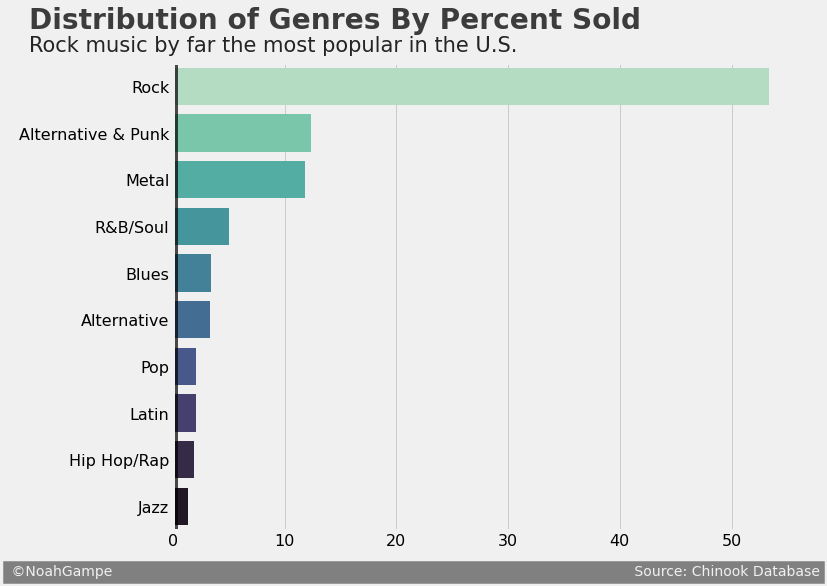

In [52]:
title = 'Distribution of Genres By Percent Sold'
sub = 'Rock music by far the most popular in the U.S.'
plot_genre(genre_df[:10], 'pct_sold', title, sub)

According to our query above, the most popular genre being sold in the US is **Rock**. However, since we have to pick from our four new artists and the respective genres, we need to look at Hip-Hop, Punk, Pop, and Blues. Looking at those 4 genres in the query results, we should order **Punk, Blues, and Pop** albums to be put into the music store, as they have 12.4%, 3.4%, and 2.1% of tracks sold in the US respectively. Based on that, the three artists we must recommend are:

* **Red Tone** (Punk)
* **Slim Jim Bites** (Blues)
* **Meteor and the Girls** (Pop)

It should be noted that these three genres combined would only make up ~17% of total sales, so in the bigger picture we should be looking out for artists in the **rock** genre, since it accounts for **53% of total sales**.

## Analyzing Employee Performance
In the Chinook store, each customer gets assigned a sales support agent whenever they make a purchase. We've been asked to analyze the purchases of customers belonging to each employee to see if any agents are performing better/worse than the others. To begin, let's build a query to find the total dollar amount of sales assigned to each sales support agent in the company.

In [60]:
query = """
/* subquery to gather each employees sales */
WITH csrep_sales AS
    (
        SELECT e.first_name || " " || e.last_name employee,
               e.hire_date,
               COUNT(i.invoice_id) num_purchases,
               COUNT(c.customer_id) customers,
               ROUND(SUM(i.total),2) total_sales
        FROM employee e
        LEFT JOIN customer c ON c.support_rep_id = e.employee_id
        INNER JOIN invoice i ON i.customer_id = c.customer_id
        WHERE e.title = 'Sales Support Agent'
        GROUP BY 1
        ORDER BY 4 DESC
    )
    
SELECT employee, 
       hire_date,
       num_purchases,
       customers,
       ROUND(customers * 100.0/ (SELECT SUM(customers) FROM csrep_sales),1) pct_customer,
       total_sales,
       ROUND(total_sales * 100.0/ (SELECT SUM(total_sales) FROM csrep_sales),1) pct_sales,
       ROUND(total_sales / num_purchases,2) avg_sale
FROM csrep_sales css
"""
employee_df = pd.read_sql_query(query, conn)

def plot_employee(df, title, sub, orient='v'):
    #figure setup
    fig = plt.figure(figsize=(10,8))
        
    #plot
    ax = sns.barplot(data=df, x='employee', y='value', hue='pct',
                     orient=orient, palette='mako_r')
    
    #lines, limits, and labels
    ax.axhline(y=0, color='black', linewidth=10, alpha=.7)
    ax.tick_params(axis='both', labelsize=16)
    ax.set_ylim(25, 39)
    ax.yaxis.label.set_visible(False)
    ax.xaxis.label.set_visible(False)
    labels = ['Customers', 'Sales']
    h,l = ax.get_legend_handles_labels()
    ax.legend(handles=h, labels=labels)

    #title & subtitle
    ax.text(x=0.01, y=0.94, s=title, fontsize=28, weight='bold', alpha=.75, transform=fig.transFigure)
    ax.text(x=0.01, y=0.9, s=sub, fontsize=21, alpha=.85, transform=fig.transFigure)
    
    #signature bar
    ax.text(x=-0.001, y=-0.01,
            s=' ©NoahGampe' + ' '*90 + ' Source: Chinook Database',
            fontsize=14, color='#f0f0f0', backgroundcolor='grey', transform=fig.transFigure)
    
    plt.show()
    
employee_melted = pd.melt(employee_df, id_vars='employee',
                          value_vars=['pct_customer', 'pct_sales'], var_name='pct')
employee_df

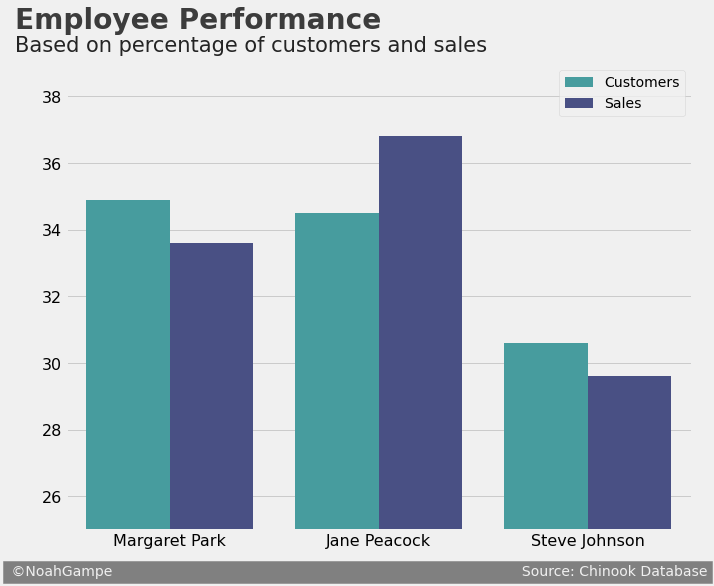

In [62]:
title = 'Employee Performance'
sub = 'Based on percentage of customers and sales'
plot_employee(employee_melted, title, sub)

As we can see from our query, Jane Peacock is the best performing employee. However, we must take into account that not every employee gets hired at the same time. If we look at the percentage of total sales, we can see that there's only a ~7% difference between the highest performing and lowest performing employees. Additionally, there is a ~6 month gap between the the hire dates for said employees - more time working means more experience, etc. If we look at the average sale amount, we can see that the bottom two performers are almost identical, at around $7.40 per sale (on average).

## Analyzing Sales By Country
Our next task is to analyze the sales data for customers from different countries. In particular, we have been directed to calculate data, for each country, on the following:

* total number of customers
* total value of sales
* average value of sales per customer
* average order value

For this analysis, if there is only a single customer from a country, we will collect them into an "Other" category.

In [ ]:
%%sql

/* sales per customer */
WITH sales_per_customer AS
    (
        SELECT c.country,
               c.customer_id,
               COUNT(i.invoice_id) num_sales,
               ROUND(SUM(i.total),2) total
        FROM customer c
        INNER JOIN invoice i ON i.customer_id = c.customer_id
        GROUP BY 1, 2
    ),

/* all countries info */
    all_countries AS
    (
        SELECT c.country,
               COUNT(c.customer_id) customers,
               ROUND(SUM(spc.total),2) total_sales,
               ROUND(AVG(spc.num_sales),2) avg_sales_per_customer,
               ROUND(AVG(spc.total),2) avg_order
        FROM customer c
        INNER JOIN sales_per_customer spc ON spc.customer_id = c.customer_id
        GROUP BY 1
    ),
    
/* countries with only 1 customer */
    only_1_customer AS
    (
        SELECT COUNT(country) country,
               COUNT(customers) customers,
               SUM(total_sales) total_sales,
               ROUND(AVG(avg_sales_per_customer),0) avg_sales_per_customer,
               ROUND(AVG(avg_order),0) avg_order
        FROM all_countries
        WHERE customers = 1
    ),
    
/* labeling countries with only 1 customer as "Other" */
    other_countries AS
    (SELECT
         CASE
               WHEN country = (SELECT country FROM only_1_customer) THEN "Other"
         END AS country,
                customers,
                total_sales,
                avg_sales_per_customer,
                avg_order
         FROM only_1_customer
    ),
    
/* countries with more than 1 customer */
    more_than_1_customer AS
    (
        SELECT *
        FROM all_countries
        WHERE customers > 1
        ORDER BY 1
    ),
    
/* both groups of countries combined */
    combined AS
    (
        SELECT * 
        FROM more_than_1_customer
        UNION
        SELECT * 
        FROM other_countries
    )
    
/* main query */
SELECT country,
       customers,
       total_sales,
       avg_sales_per_customer,
       avg_order
FROM (
    SELECT combined.*,
           CASE
               WHEN combined.country = "Other" THEN 1
               ELSE 0
           END AS sort
           FROM combined
     )
ORDER BY sort ASC, 3 DESC;

## Albums vs. Tracks Purchases

The Chinook store is setup in a way that allows customer to make purchases in one of the two ways:

* purchase a whole album
* purchase a collection of one or more individual tracks.

The store does not let customers purchase a whole album, and then add individual tracks to that same purchase (unless they do that by choosing each track manually). When customers purchase albums they are charged the same price as if they had purchased each of those tracks separately.

Management are currently considering changing their purchasing strategy to save money. The strategy they are considering is to purchase only the most popular tracks from each album from record companies, instead of purchasing every track from an album.

We have been asked to find out what percentage of purchases are individual tracks vs whole albums, so that management can use this data to understand the effect this decision might have on overall revenue.

It is very common when you are performing an analysis to have 'edge cases' which prevent you from getting a 100% accurate answer to your question. In this instance, we have two edge cases to consider:

* Albums that have only one or two tracks are likely to be purchased by customers as part of a collection of individual tracks.
* Customers may decide to manually select every track from an album, and then add a few individual tracks from other albums to their purchase.

In the first case, since our analysis is concerned with maximizing revenue we can safely ignore albums consisting of only a few tracks. The company has previously done analysis to confirm that the second case does not happen often, so we can ignore this case also.

In order to answer the question, we're going to have to identify whether each invoice has all the tracks from an album. We can do this by getting the list of tracks from an invoice and comparing it to the list of tracks from an album. We can find the album to compare the purchase to by looking up the album that one of the purchased tracks belongs to. It doesn't matter which track we pick, since if it's an album purchase, that album will be the same for all tracks.


In [ ]:
%%sql

/* grabs relevant information about each invoice */
WITH invoice_info AS
    (SELECT il.invoice_id,
            t.album_id  
     FROM invoice_line il
          INNER JOIN track t 
          ON t.track_id = il.track_id
     GROUP BY 1),
    
    album_or_track AS
    (SELECT ii.*,            
            CASE 
            /* compare track bought, to track in store */
            WHEN (SELECT il.track_id
                    FROM invoice_line il
                   WHERE il.invoice_id = ii.invoice_id
                  EXCEPT
                  SELECT t.track_id
                    FROM track t
                   WHERE t.album_id = ii.album_id) IS NULL            
                     AND
            /* compare track in store, to track bought */     
                 (SELECT t.track_id
                    FROM track t
                   WHERE t.album_id = ii.album_id
                  EXCEPT
                  SELECT il.track_id
                    FROM invoice_line il
                   WHERE il.invoice_id = ii.invoice_id) IS NULL
            THEN "Albums"
            ELSE "Tracks"
            END AS purchase
       FROM invoice_info ii)

/* main query */
SELECT purchase,
       COUNT(*) num_invoices,
       ROUND(COUNT(*) * 100.0 / (SELECT COUNT(*)
                               FROM invoice) ,2) pct
FROM album_or_track
GROUP BY 1
ORDER BY 2 DESC; 

From the results of our query, we can see that the sales of individual tracks are 4 times higher than those of albums. This implies that for maximum revenue, the store should focus on purchasing only the popular tracks from albums instead of purchasing the entire album.

## Most Popular Artist / Artist Used In Most Playlists
Let's do another query to see if we can find out which is the most popular artist in the Chinook store. For this, we're going to identify which artist is used in playlists the most, as well as the artist that is used in the most playlists. We'll have to use the artist, album, track, and playlist_track tables.

In [ ]:
%%sql

WITH playlist_info AS
   (SELECT ar.name,
           al.album_id,
           t.track_id,
           g.name genre,
           COUNT(pt.playlist_id) tracks_in_playlist,
           COUNT(DISTINCT pt.playlist_id) num_playlist
      FROM artist ar
           INNER JOIN album al ON ar.artist_id = al.artist_id
           INNER JOIN track t ON t.album_id = al.album_id
           INNER JOIN genre g ON g.genre_id = t.genre_id
           INNER JOIN playlist_track pt ON pt.track_id = t.track_id
     GROUP BY 1
     ORDER BY 5 DESC)
    
SELECT pi.name artist,
       pi.genre,
       pi.tracks_in_playlist tracks_in_playlists,
       pi.num_playlist 
FROM playlist_info pi
GROUP BY 1
ORDER BY 3 DESC
LIMIT 10;

From the above query, we can see the artist that have the most songs in playlists. Iron Maiden leads the charge with 516 songs spread between 4 different playlists. However, the question technically is asking which artist is used in the most *playlists*. For this information, we'll have to adject our query a little bit. In the previous query we ordered our result table by tracks_in_playlists. However, if we simply order it by num_playlist, we can find out which artists are used on the most playlists.

In [ ]:
%%sql

WITH playlist_info AS
   (   SELECT ar.name,
              al.album_id,
              t.track_id,
              g.name genre,
              COUNT(pt.playlist_id) tracks_in_playlist,
              COUNT(DISTINCT pt.playlist_id) num_playlist
         FROM artist ar
              INNER JOIN album al ON ar.artist_id = al.artist_id
              INNER JOIN track t ON t.album_id = al.album_id
              INNER JOIN genre g ON g.genre_id = t.genre_id
              INNER JOIN playlist_track pt ON pt.track_id = t.track_id
     GROUP BY 1
     ORDER BY 5 DESC)

SELECT pi.name artist,
       pi.genre,
       pi.tracks_in_playlist tracks_in_playlists,
       pi.num_playlist 
FROM playlist_info pi
GROUP BY 1
ORDER BY 4 DESC
LIMIT 10;

So the artist Eugene Ormandy has appeared on 7 different playlists, more than any other artist in the Chinook Music Store. However, he only has 15 tracks spread across those playlists. Compared to Iron Maiden, who has 516 tracks across 4 playlists, I think it's a safe bet to say that Iron Maiden is the most popular artist. If we compare both tables, we can see that the most used artists in playlist have a variety of genres, whereas the Classical genre seems to be used on more playlists, despite having significantly fewer tracks.

For maximum profit, Chinook Music should opt to buy more songs in the Metal, Pop, and Punk/Rock genres instead of those in the Classical genre.

## Tracks Purchased vs Not Purchased

Now we want to identify the number of tracks that fall into both categories (purchased and not purchased). For this, we will look into the track and invoice_line tables.

In [ ]:
%%sql

WITH sales AS
    (SELECT (COUNT(DISTINCT t.track_id)) all_tracks,
            (COUNT(DISTINCT il.track_id)) sold_tracks
     FROM track t
          LEFT JOIN invoice_line il ON il.track_id = t.track_id)
    
SELECT all_tracks,
       sold_tracks,
       ROUND(sold_tracks * 100.0 / all_tracks ,2) sold_pct
FROM sales s;

Very surprisingly, only ~52% of the entire Chinook Music catalog has sold. This can be for a number of reasons, such as:

* marketing and promotion (or lack of)
* not stocking popular music
* employee motivation & effort to engage with customers

This is a big area where Chinook can improve on, as having nearly half of their entire stock isn't being touched at all.

In [ ]:
%%sql

SELECT ar.name artist,
       g.name genre,
       COUNT(il.track_id) tracks_sold
FROM track t
LEFT JOIN invoice_line il ON il.track_id = t.track_id
INNER JOIN album al ON al.album_id = t.album_id
INNER JOIN artist ar ON ar.artist_id = al.artist_id
INNER JOIN genre g ON g.genre_id = t.genre_id
GROUP BY 1
HAVING tracks_sold = 0;

A quick glance at the above query shows that the majority of artists that haven't sold any tracks are artists that belong to the Classical genre. In the interest of profitability, it's recommended that Chinook either cut back on stocking Classical music in their store, or find a way to get these artists in the customers eyes.

## Protected vs. Non-Protected Media - Do Customers Care?

Our final analysis will look at whether or not a tracks media type has an effect on sales. Do customers care if the media they purchase is protected or not? Let's take a look. First, what kind of media types are there?

In [ ]:
%%sql

WITH track_stats AS
    (SELECT mt.name media_type,
            COUNT(t.track_id) num_tracks
     FROM track t
     LEFT JOIN media_type mt ON mt.media_type_id = t.media_type_id
     GROUP BY 1)
    
SELECT media_type,
       num_tracks,
       ROUND(num_tracks * 100.0 / (SELECT COUNT(t.track_id) FROM track t),2) pct
        
FROM track_stats ts
GROUP BY 1;

We can see from the query above that the Chinook store's protected tracks are labelled as the following media_types:

* Protected AAC audio file
* Protected MPEG-4 video file

Non-Protected tracks are identified with the following media_types:

* AAC audio file
* MPEG audio file
* Purchased AAC audio file

We immediately see that Non-Protected MPEG audio files make up the majority of the tracks in the store at around 86%. For simplicities sake, we can condense the above query to only show the two different media_types: Protected and Non-Protected.

In [ ]:
%%sql

WITH protection AS
    (SELECT CASE
                WHEN mt.name LIKE 'Protected%' THEN 'Protected'
                ELSE 'Non-Protected'
            END AS m_type            
       FROM track t
            INNER JOIN media_type mt ON mt.media_type_id = t.media_type_id)
    
SELECT m_type media_type,
       COUNT(m_type) total,
       ROUND(COUNT(m_type) * 100.0 / (SELECT COUNT(*) FROM protection),2) pct
FROM protection
GROUP BY 1;
        

As we can see from the above result, over 87% of the inventory is Non-Protected music. An initial assumption would be that the type of media (protected vs non-protected) wouldn't really have any effect on a customer's decision to purchase a track, but let's dive a little deeper and see the sales numbers behind these two categories.

In [ ]:
%%sql

WITH protection AS
    (SELECT CASE
                WHEN mt.name LIKE 'Protected%' THEN 'Protected'
                ELSE 'Non-Protected'
            END AS m_type
       FROM track t
            INNER JOIN media_type mt ON mt.media_type_id = t.media_type_id
            INNER JOIN invoice_line il ON il.track_id = t.track_id)
    
SELECT m_type media_type,
       COUNT(m_type) total_sold,
       ROUND(COUNT(m_type) * 100.0 / (SELECT COUNT(*) FROM protection),2) pct_sold
FROM protection p
GROUP BY 1;

Here we can see that over 90% of tracks sold are Non-Protected. Whether or not customers stop and think about the Digital Rights Management (DRM) of the music they're about to buy is hard to say, but it does make sense that people would be more willing to buy non-protected music so that they can listen to it on whatever devices they wish.

#  Conclusions

In this analysis of the Chinook Music Store, we have examined the Chinook database to find answers to our business questions. Below is the summary of all of our work:

* Among the four artists/albums in consideration, the following three should be considered for purchasing and advertising in the US:
    * **Red Tone** (Punk)
    * **Slim Jim Bites** (Blues)
    * **Metor and the Girls** (Pop)
* Among our three sales support agents, **Jane Peacock** is the most effective, with **Margaret Park** being the least effective. However, age and length of employment play a big factor in an employee's performance.
* The biggest portion of the market is located in the USA - both in terms of total sales and number of customers.
* **Individual tracks** tend to sell much more than whole albums. Because of this, it is recommened that Chinook only purchase the most popular tracks from each album from the record companies.
* While the **Classical** genre appears on the most number of playlists, it is not the most popular genre of music overall. Bands in the **Rock** genre are the most popular, and thus should be focused on more for a profitable business strategy.
* Almost half of the entire stock in the Chinook store has never been bought. There are several solutions to this, including:
    * improved advertising and marketing
    * sales promotions
    * re-consideration of which music to stock
    * more employee interaction and performance
* **Non-Protected** media types sell far more than **Protected** media types. Thus, Chinook should potentially avoid stocking **protected** media types in the futue.